<a href="https://colab.research.google.com/github/KjelleJ/enkla-ai-experiment/blob/main/AIX_9_rl_frozen_lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


#REINFORCEMENT LEARNING - FROZEN LAKE
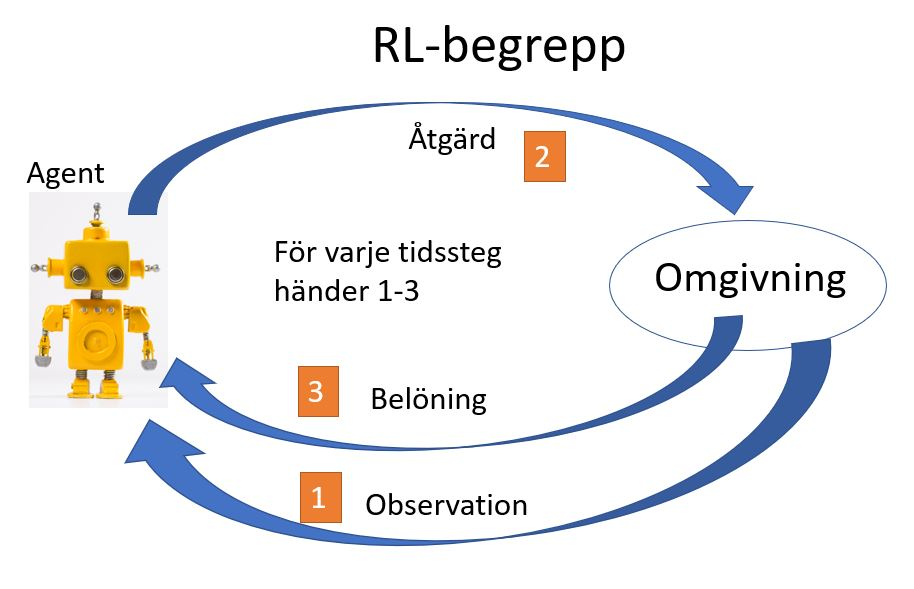

---



##Vårt problem

En liten figur ska ta sig fram på en frusen sjö från ruta 0 till ruta 15 där det finns en present som belöning. Det finns några farliga vakar och dessutom är isen hal så det är lätt att falla i en vak. Vi ska kolla på 3 fall med hjälp av Q-tabeller:
* 0: Otränad tabell på hal is
* 1: Tränad tabell på hal is
* 2: Tränad tabell på is som inte är hal

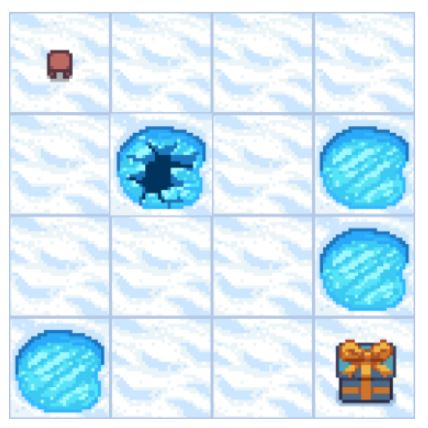


# OpenAI Gym/Gymnasium - ger omgivningen till vår agent

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [ ]:
# Installera gym
#!pip install gym
import matplotlib.pyplot as plt
import gymnasium as gym
print(gym.envs.registry.keys())

## BESKRIVNING
**Action/Åtgärd**:
Flyttar figuren ett steg:
0 till vänster,
1 ner,
2 till höger,
3 upp

**State/Tillstånd**: 0-15. I vilken ruta figuren finns. Det är 16 rutor.

**Q-tabellen** innehåller 16 rader, en rad för varje tillstånd.
Varje rad innehåller: tillstånd, framtränat värde för varje åtgärd (4 värden). Index för max-värdet ger åtgärden 0-3.

**Slippery/Halt**. Om det är halt kommer figuren att röra sig i avsedd riktning med sannolikheten 1/3 eller vinkelrätt, ett av två håll båda med sannolkheten 1/3. Alltså aldrig bakåt mot avsedd riktning (enligt Q-tabllen). Om det är halt är vårt problem ganska knepigt. Annars är det trivialt.




---


# TRÄNA OCH UTVÄRDERA Q-TABELLER


---



## Funktionen **trana**: Träna och utvärdera en Q-tabell

https://github.com/OmarAflak/FrozenLake-QLearning/blob/master/qlearning.py

In [ ]:
def trana(fall):
  """Tränar och utvärdera en Q-tabell för ett givet fall.
  0 - otränad
  1 - hal is
  2 - inte hal is
  Rerurnerar tabellen"""
  import numpy as np
  #import joblib

  # Environment
  if fall == 2:
    is_slippery = False
  else:
    is_slippery = True

  env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=is_slippery).env
  inputCount = env.observation_space.n
  actionsCount = env.action_space.n

  # Init Q-Table
  Q = {}
  for i in range(inputCount):
      Q[i] = np.random.rand(actionsCount)

  # Hyperparameters
  lr = 0.33
  lrMin = 0.001
  lrDecay = 0.9999
  gamma = 1.0
  epsilon = 1.0
  epsilonMin = 0.001
  epsilonDecay = 0.97
  episodes = 2000
  ntest = 100

  if fall != 0:
    print("\nTrain for number of episodes:", episodes)
    for i in range(episodes):
        s = env.reset()[0]
        done = False
        while not done:
            if np.random.random() < epsilon:
                # exploration phase
                a = np.random.randint(0, actionsCount)
            else:
                # exploatation phase (greedy)
                a = np.argmax(Q[s])

            newS, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            # modify Q-table
            Q[s][a] = Q[s][a] + lr * (r + gamma * np.max(Q[newS]) - Q[s][a])
            s = newS
            # make learning rate smaller
            if lr > lrMin:
                lr *= lrDecay
            # make epsilon smaller
            if not r==0 and epsilon > epsilonMin:
                epsilon *= epsilonDecay
    print("")
    print("Learning Rate :", lr)
    print("Epsilon :", epsilon)
    #joblib.dump(Q, "Q_frozen_lake.pkl")

  # Testing

  print("\nPlay Game on", ntest, "episodes...")

  avg_r = 0
  for i in range(ntest):
      s = env.reset()[0]
      done = False

      while not done:
          a = np.argmax(Q[s])
          newS, r, done, _, _ = env.step(a)
          s = newS

      avg_r += r/ntest

  print("Average reward on", ntest, "episodes:", avg_r)
  return Q

## Ta fram tabell **Q_slump** som innehåller slumpade värden

In [ ]:
Q_slump = trana(0)

## Träna tabell **Q_hal** för hal is

In [ ]:
Q_hal = trana(1)

In [ ]:
Q_hal

## Träna tabell **Q_inte_hal** för is som inte är hal

In [ ]:
Q_inte_hal = trana(2)

In [ ]:
# Q-tabell för ett trivialt fall (inte halt). Vi kan från tabellen se vilken
# väg figuren går - och alltid densamma.
# Index i vektorn: 0 gå Vänster, 1 gå Ner, 2 gå Höger, 3 gå Upp
# T.ex. 0 H -> 1 H -> 2 N -> 6 N -> 10 N -> 14 H -> 15 PRESENT
#
Q_inte_hal



---

# SPELA MED OLIKA Q-TABELLER


---



## Funktionen **spela** för att spela med en given Q-tabell

In [ ]:
def spela(fall, Q):
  """Spelar ett spel med tabllen Q för ett givet fall.
  0 - otränad
  1 - hal is
  2 - inte hal is"""
  import gymnasium as gym
  import numpy as np
  from IPython.display import Video
  from gymnasium.utils.save_video import save_video

  if fall == 2:
    is_slippery = False
  else:
    is_slippery = True
  env = gym.make("FrozenLake-v1", is_slippery=is_slippery, max_episode_steps=200, render_mode="rgb_array_list")
  _ = env.reset()
  step_starting_index = 0
  episode_index = 0
  state = 0
  for step_index in range(199):
    #action = env.action_space.sample()
    action = np.argmax(Q[state])
    state, _, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        save_video(
          frames=env.render(),
          video_folder="./",
          fps=env.metadata["render_fps"],
          step_starting_index=step_starting_index,
          episode_index=episode_index
        )
        break
        env.reset()

  env.close()
  print("\n\n\n\n\n")
  print("*** SLUT efter %d steg " % (step_index+1))

## Spela med slumpad Q-tabell på hal is

In [ ]:
from IPython.display import Video
spela(0, Q_slump)
Video("./rl-video-episode-0.mp4", embed=True, html_attributes="autoplay")


## Spela med tränad Q-tabell på hal is

In [ ]:
from IPython.display import Video
spela(1, Q_hal)
Video("./rl-video-episode-0.mp4", embed=True, html_attributes="autoplay")

## Spela med tränad Q-tabell på is som inte är hal

In [ ]:
# Enligt tidigare Q-tabell kan sekvensen vara :
# 0 H -> 1 H -> 2 N -> 6 N -> 10 N -> 14 H -> 15 PRESENT
from IPython.display import Video
spela(2, Q_inte_hal)
Video("./rl-video-episode-0.mp4", embed=True, html_attributes="autoplay")